# Redes Neuronales Convolucionales (CNN)

Este notebook cubre las Redes Neuronales Convolucionales (CNN), fundamentales para el procesamiento de imágenes y visión por computadora.

## Introducción

Las CNN son un tipo especial de red neuronal diseñada para procesar datos con estructura de cuadrícula, como imágenes. Utilizan operaciones de convolución para detectar características locales.

### Conceptos Clave

- **Convolución**: Operación que aplica filtros (kernels) para detectar características
- **Pooling**: Reducción de dimensionalidad preservando información importante
- **Feature Maps**: Mapas de características extraídas por las capas convolucionales
- **Padding**: Añadir píxeles alrededor de la imagen para controlar el tamaño de salida
- **Stride**: Paso de desplazamiento del kernel durante la convolución


## Importar Librerías


In [1]:
# Suprimir mensajes informativos de TensorFlow
# IMPORTANTE: Estas variables deben establecerse ANTES de importar TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime INFO (1) y WARNING (2), muestra solo ERROR (3)
# Suprimir mensajes de absl (usado por TensorFlow)
os.environ['ABSL_MIN_LOG_LEVEL'] = '2'
# Deshabilitar GPU por defecto para evitar mensajes de inicialización
# Si necesitas usar GPU, comenta la siguiente línea después de ejecutar esta celda
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Fuerza uso de CPU (sin mensajes de GPU)
# Redirigir stderr temporalmente durante la importación y configuración para capturar warnings de GPU
import sys
from io import StringIO
stderr_backup = sys.stderr
stderr_capture = StringIO()
sys.stderr = stderr_capture

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Intentar importar TensorFlow/Keras
try:
    import tensorflow as tf
    # Configurar logging de TensorFlow para suprimir mensajes adicionales
    tf.get_logger().setLevel('ERROR')
    # Suprimir mensajes de absl (usado por TensorFlow para logging)
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)
    
    # Configurar dispositivos: usar CPU por defecto (sin mensajes de GPU)
    # Si necesitas GPU, comenta la línea os.environ['CUDA_VISIBLE_DEVICES'] = '-1' arriba
    # y descomenta las siguientes líneas:
    # gpus = tf.config.list_physical_devices('GPU')
    # if gpus:
    #     for gpu in gpus:
    #         tf.config.experimental.set_memory_growth(gpu, True)
    #     print(f"✓ GPU detectada: {len(gpus)} dispositivo(s)")
    
    # Limpiar el buffer de stderr
    stderr_capture.seek(0)
    stderr_capture.truncate(0)
    print("ℹ Usando CPU (sin mensajes de GPU)")
    
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.datasets import mnist, cifar10
    from tensorflow.keras.utils import to_categorical
    
    # Restaurar stderr después de toda la configuración
    sys.stderr = stderr_backup
    
    TENSORFLOW_AVAILABLE = True
    print(f"✓ TensorFlow versión: {tf.__version__}")
    print("TensorFlow está disponible. Puedes ejecutar todos los ejemplos.")
except ImportError:
    # Restaurar stderr incluso si falla la importación
    sys.stderr = stderr_backup
    TENSORFLOW_AVAILABLE = False
    print("⚠ TensorFlow no está instalado.")
    print("   Para instalar TensorFlow, ejecuta: pip install tensorflow")
    print("   El notebook mostrará ejemplos de código pero no los ejecutará.")
except Exception as e:
    # Si hay cualquier otro error (como problemas de GPU), forzar CPU
    stderr_capture.seek(0)
    stderr_capture.truncate(0)
    sys.stderr = stderr_backup
    print(f"⚠ Error al configurar TensorFlow: {e}")
    print("   Intentando usar solo CPU...")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    try:
        # Redirigir stderr nuevamente para la segunda importación
        sys.stderr = StringIO()
        import tensorflow as tf
        tf.get_logger().setLevel('ERROR')
        tf.config.set_visible_devices([], 'GPU')
        from tensorflow import keras
        from tensorflow.keras import layers, models
        from tensorflow.keras.datasets import mnist, cifar10
        from tensorflow.keras.utils import to_categorical
        sys.stderr = stderr_backup
        TENSORFLOW_AVAILABLE = True
        print(f"✓ TensorFlow versión: {tf.__version__} (modo CPU)")
        print("TensorFlow está disponible en modo CPU.")
    except:
        sys.stderr = stderr_backup
        TENSORFLOW_AVAILABLE = False
        print("❌ No se pudo inicializar TensorFlow.")

np.random.seed(42)
if TENSORFLOW_AVAILABLE:
    tf.random.set_seed(42)
    
# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')


ℹ Usando CPU (sin mensajes de GPU)
✓ TensorFlow versión: 2.20.0
TensorFlow está disponible. Puedes ejecutar todos los ejemplos.


## 1. Operación de Convolución desde Cero

Implementemos la operación de convolución básica para entender cómo funciona.


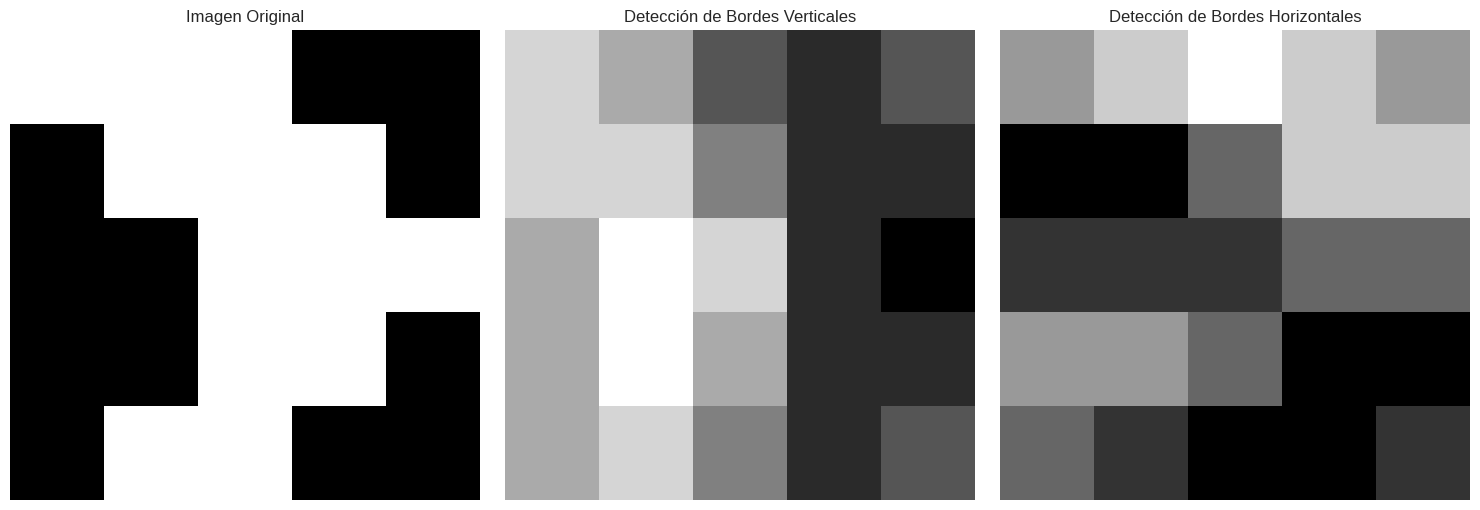

Operación de convolución completada
Tamaño imagen original: (5, 5)
Tamaño kernel: (3, 3)
Tamaño salida (con padding=1): (5, 5)


In [2]:
def convolve2d(image, kernel, padding=0, stride=1):
    """
    Aplica convolución 2D a una imagen
    
    Parameters:
    - image: array 2D (alto, ancho)
    - kernel: array 2D (alto_kernel, ancho_kernel)
    - padding: número de píxeles a añadir alrededor
    - stride: paso de desplazamiento
    """
    # Añadir padding
    if padding > 0:
        image = np.pad(image, padding, mode='constant', constant_values=0)
    
    # Dimensiones
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calcular dimensiones de salida
    out_h = (img_h - kernel_h) // stride + 1
    out_w = (img_w - kernel_w) // stride + 1
    
    # Inicializar output
    output = np.zeros((out_h, out_w))
    
    # Aplicar convolución
    for i in range(0, out_h):
        for j in range(0, out_w):
            # Extraer región
            region = image[i*stride:i*stride+kernel_h, j*stride:j*stride+kernel_w]
            # Multiplicar elemento por elemento y sumar
            output[i, j] = np.sum(region * kernel)
    
    return output

# Ejemplo: Crear imagen simple
image = np.array([
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0]
])

# Kernel de detección de bordes verticales
kernel_vertical = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])

# Kernel de detección de bordes horizontales
kernel_horizontal = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
])

# Aplicar convolución
output_vertical = convolve2d(image, kernel_vertical, padding=1, stride=1)
output_horizontal = convolve2d(image, kernel_horizontal, padding=1, stride=1)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(output_vertical, cmap='gray')
axes[1].set_title('Detección de Bordes Verticales')
axes[1].axis('off')

axes[2].imshow(output_horizontal, cmap='gray')
axes[2].set_title('Detección de Bordes Horizontales')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Operación de convolución completada")
print(f"Tamaño imagen original: {image.shape}")
print(f"Tamaño kernel: {kernel_vertical.shape}")
print(f"Tamaño salida (con padding=1): {output_vertical.shape}")


## 2. Pooling (Max Pooling y Average Pooling)

El pooling reduce la dimensionalidad y ayuda a hacer el modelo más robusto a pequeñas traslaciones.


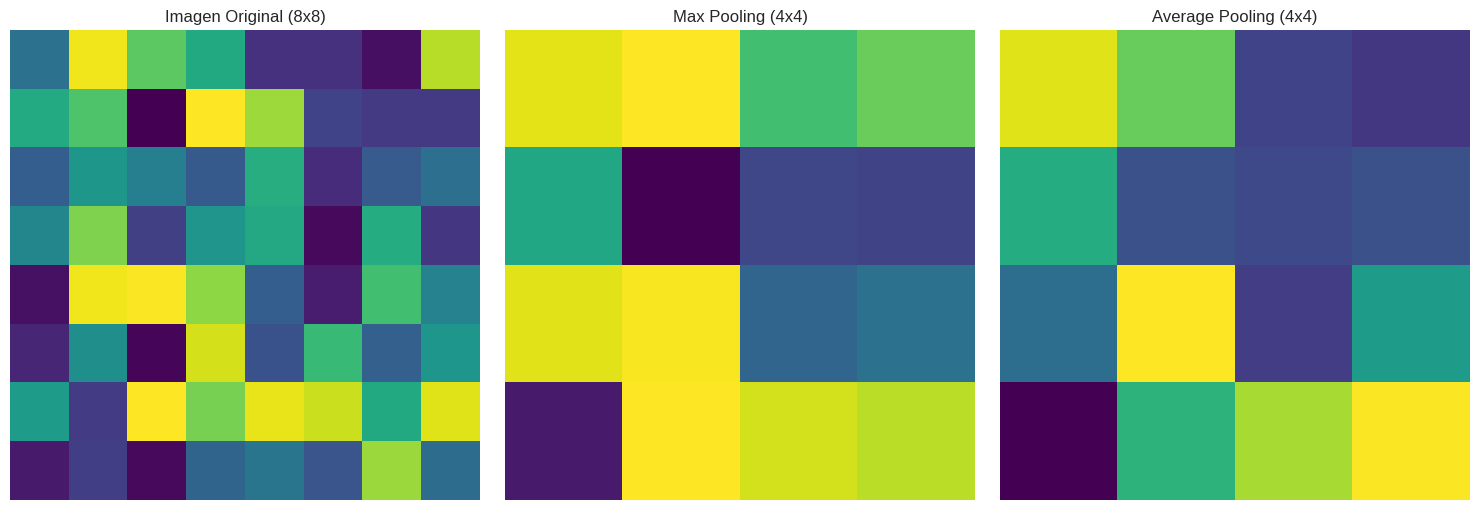

Tamaño original: (8, 8)
Tamaño después de pooling: (4, 4)
Reducción: 4.0x


In [3]:
def max_pooling(image, pool_size=2, stride=2):
    """Max Pooling: toma el valor máximo en cada región"""
    h, w = image.shape
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            region = image[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            output[i, j] = np.max(region)
    
    return output

def average_pooling(image, pool_size=2, stride=2):
    """Average Pooling: toma el promedio en cada región"""
    h, w = image.shape
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            region = image[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            output[i, j] = np.mean(region)
    
    return output

# Crear imagen de ejemplo más grande
image = np.random.rand(8, 8) * 255

# Aplicar pooling
max_pooled = max_pooling(image, pool_size=2, stride=2)
avg_pooled = average_pooling(image, pool_size=2, stride=2)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='viridis')
axes[0].set_title('Imagen Original (8x8)')
axes[0].axis('off')

axes[1].imshow(max_pooled, cmap='viridis')
axes[1].set_title('Max Pooling (4x4)')
axes[1].axis('off')

axes[2].imshow(avg_pooled, cmap='viridis')
axes[2].set_title('Average Pooling (4x4)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Tamaño original: {image.shape}")
print(f"Tamaño después de pooling: {max_pooled.shape}")
print(f"Reducción: {image.size / max_pooled.size:.1f}x")


## 3. CNN con TensorFlow/Keras

Si TensorFlow está disponible, construiremos una CNN completa para clasificación de imágenes.


✓ Forzando uso de CPU para evitar errores de CUDA


2025-12-07 21:01:06.190353: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Arquitectura del modelo CNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo (esto puede tardar unos minutos)...
Epoch 1/3
422/422 - 9s - 22ms/step - accuracy: 0.9170 - loss: 0.2689 - val_accuracy: 0.9817 - val_loss: 0.0682
Epoch 2/3
422/422 - 8s - 19ms/step - accuracy: 0.9789 - loss: 0.0677 - val_accuracy: 0.9843 - val_loss: 0.0543
Epoch 3/3
422/422 - 8s - 19ms/step - accuracy: 0.9851 - loss: 0.0473 - val_accuracy: 0.9890 - val_loss: 0.0419

Precisión en test: 0.9896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


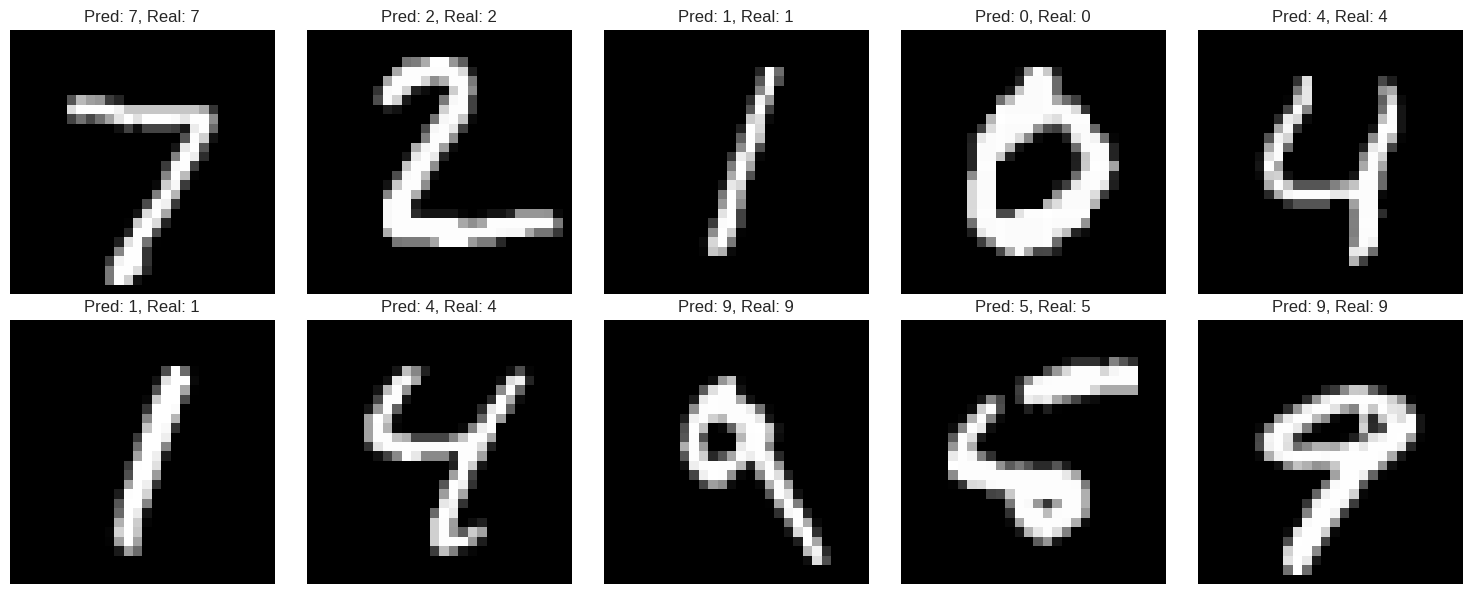

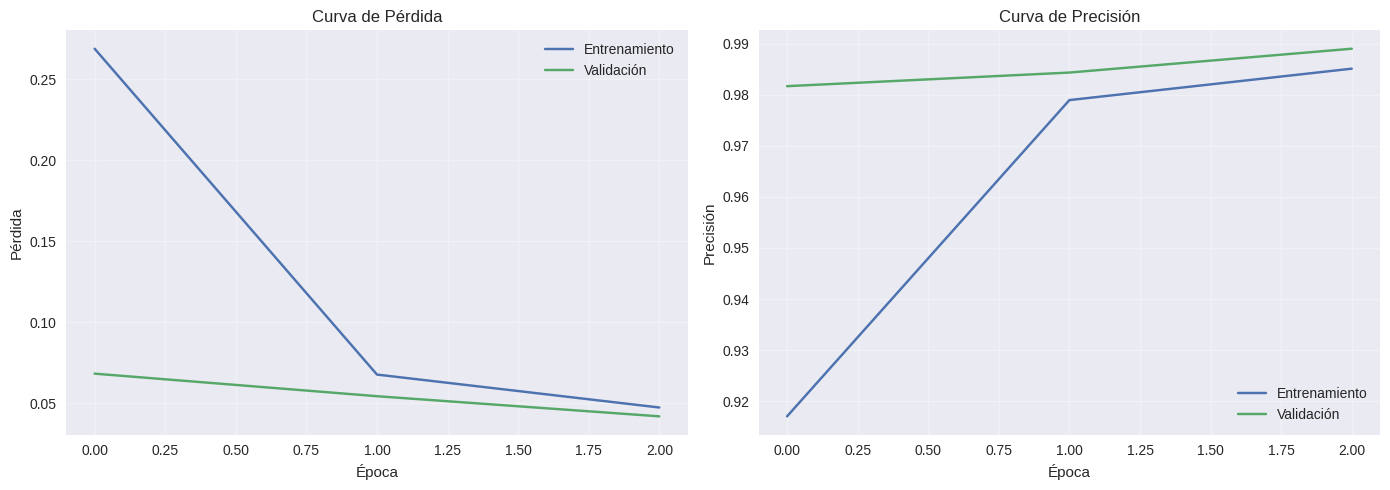

In [4]:
if TENSORFLOW_AVAILABLE:
    # Forzar uso de CPU explícitamente (evita errores de CUDA)
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    # Asegurar que TensorFlow use solo CPU
    tf.config.set_visible_devices([], 'GPU')
    
    # Suprimir warnings adicionales durante la ejecución
    import logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # Verificar que estamos usando CPU
    print("✓ Forzando uso de CPU para evitar errores de CUDA")
    
    # Cargar datos MNIST
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Preprocesar datos
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255.0
    
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    # Construir modelo CNN
    model = models.Sequential([
        # Primera capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        # Segunda capa convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Tercera capa convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Aplanar y capas densas
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    # Compilar modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Resumen del modelo
    print("Arquitectura del modelo CNN:")
    model.summary()
    
    # Entrenar modelo (solo unas pocas épocas para demostración)
    print("\nEntrenando modelo (esto puede tardar unos minutos)...")
    # Usar verbose=2 para mostrar solo una línea por época (más limpio)
    history = model.fit(X_train, y_train, 
                       epochs=3, 
                       batch_size=128,
                       validation_split=0.1,
                       verbose=2)
    
    # Evaluar
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nPrecisión en test: {test_acc:.4f}")
    
    # Visualizar algunas predicciones
    predictions = model.predict(X_test[:10])
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[:10], axis=1)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[row, col].set_title(f'Pred: {predicted_labels[i]}, Real: {true_labels[i]}')
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Visualizar curva de aprendizaje
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['loss'], label='Entrenamiento')
    axes[0].plot(history.history['val_loss'], label='Validación')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Pérdida')
    axes[0].set_title('Curva de Pérdida')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['accuracy'], label='Entrenamiento')
    axes[1].plot(history.history['val_accuracy'], label='Validación')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Precisión')
    axes[1].set_title('Curva de Precisión')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("TensorFlow no está disponible. Instala con: pip install tensorflow")
    print("\nEjemplo de arquitectura CNN típica:")
    print("""
    Input (28x28x1)
        ↓
    Conv2D (32 filtros, 3x3) + ReLU
        ↓
    MaxPooling2D (2x2)
        ↓
    Conv2D (64 filtros, 3x3) + ReLU
        ↓
    MaxPooling2D (2x2)
        ↓
    Conv2D (64 filtros, 3x3) + ReLU
        ↓
    Flatten
        ↓
    Dense (64 neuronas) + ReLU
        ↓
    Dense (10 neuronas) + Softmax
        ↓
    Output (10 clases)
    """)


## 4. Resumen

### Componentes de una CNN

1. **Capa Convolucional**: Detecta características locales usando filtros
2. **Capa de Pooling**: Reduce dimensionalidad y previene sobreajuste
3. **Capa de Activación**: Introduce no-linealidad (ReLU, sigmoide, etc.)
4. **Capa Flatten**: Convierte mapas 2D en vectores 1D
5. **Capa Densa**: Clasificación final

### Ventajas de las CNN

- **Invariante a traslación**: Detectan características independientemente de su posición
- **Eficiencia**: Comparten parámetros (pesos del kernel)
- **Jerarquía**: Aprenden características de bajo a alto nivel
- **Robustez**: Menos parámetros que redes completamente conectadas

### Aplicaciones

- Clasificación de imágenes
- Detección de objetos
- Segmentación semántica
- Reconocimiento facial
- Procesamiento de video
